# Comparing Molecules among Molecular Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

RDKit WARNING: [19:18:54] Enabling RDKit 2019.09.1 jupyter extensions


#### Load the data

In [2]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './fxa_rdkit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)

In [3]:
print(lig_datasets.keys())
print('\n' + '-'* 50 + '\nExample:')
lig_datasets['COCRYS'].head(3)

dict_keys(['COCRYS', 'DUD', 'DEKOIS'])

--------------------------------------------------
Example:


,Activity,mol_rdk,sanitized
Lig,,,
RPR,active,<rdkit.Chem.rdchem.Mol object at 0x7f85950a8830>,False
815,active,<rdkit.Chem.rdchem.Mol object at 0x7f85950a8870>,True
PR2,active,<rdkit.Chem.rdchem.Mol object at 0x7f85950a88b0>,True


## Using RDKit to evaluate some molecular descriptors
##### The following function computes some features like Molecular Mass, number of heavy atoms, number of rotamers and number of rings.

In [4]:
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

# Get the molecular weight and # of heavy atoms for each ligand
for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']]

### Plots

In [5]:
# Import some helper functions
from helper_functions_2 import violin_plot_helper, swarm_plot_helper

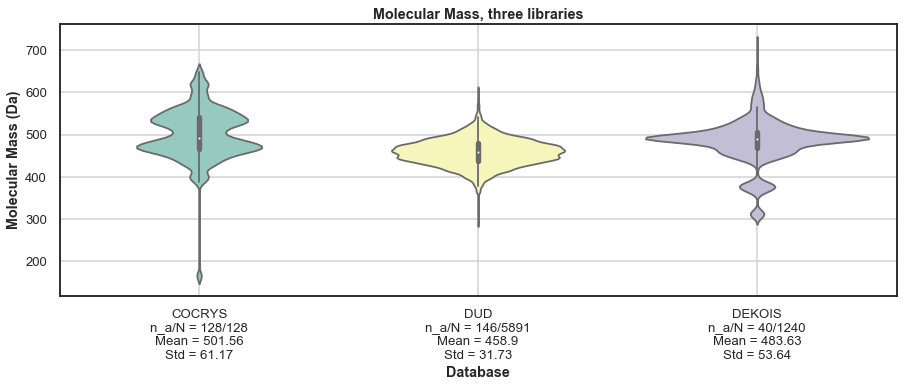

In [7]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries', palette= 'Set3',
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=False, )

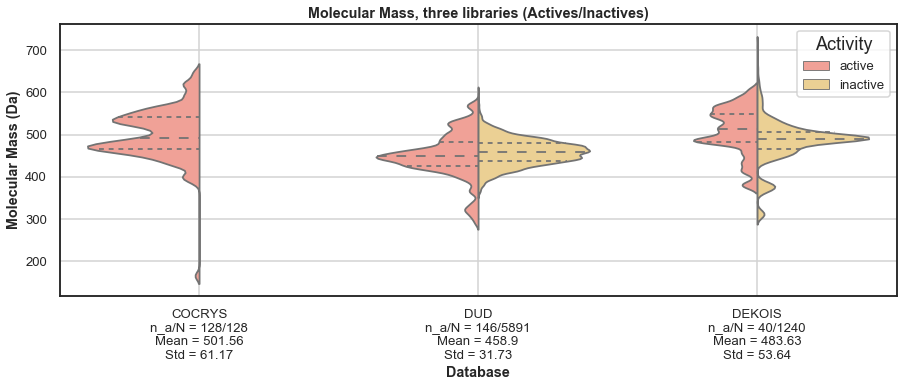

In [8]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=True)

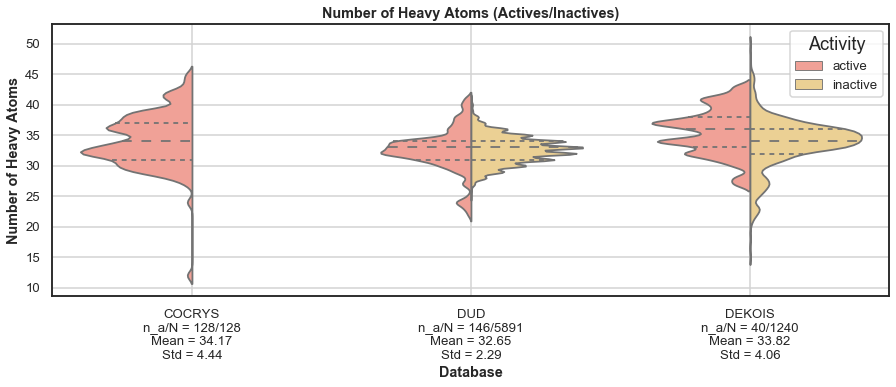

In [9]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split_by_activity=True)

## Merge the data frames

In [15]:
# Get a dataframe for each library 
library_names = ['COCRYS', 'DEKOIS', 'DUD']
dfs_list = []

# add a new column
for name in library_names:
    df = lig_datasets[name]
    # Add new column with its name
    df['library'] = name
    # Append to the df list
    dfs_list.append(df)

# Concat
df_all_mols = pd.concat(dfs_list, ignore_index=False).reset_index()

## Compute Fingerprints

### Extract fingerprint dataframes

In [39]:
%%time
# compute MACCS Fingerprints
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs

def fps_to_array(fps, drop_constant_cols=True):
    """Convert a list of molecular fingerprints into a 
    numpy m*n array, where n = # molecules and n = # fps"""
    def fp2arr(fp):
        arr = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    X = np.asarray([fp2arr(fp) for fp in fps])
    if drop_constant_cols:
        X = pd.DataFrame(X)
        X = X.loc[:, X.var() != 0.0] 
    return X 


# Maccs Fingerprints
fps_all_maccs = [MACCSkeys.GenMACCSKeys(i) for i in df_all_mols.mol_rdk]
X_all_maccs = fps_to_array(fps_all_maccs)
print("MACCS Fps:", X_all_maccs.shape)
    
# Morgan Fingerprints
fps_all_morgan = [GetMorganFingerprintAsBitVect(i, radius=2) for i in df_all_mols.mol_rdk]
X_all_morgan = fps_to_array(fps_all_morgan)
print("Morgan Fps:", X_all_morgan.shape)

# RDKit Fingerprints
fps_all_rdk = [Chem.RDKFingerprint(i) for i in df_all_mols.mol_rdk]
X_all_rdk = fps_to_array(fps_all_rdk)
print("RDKit Fps:", X_all_rdk.shape)


MACCS Fps: (7259, 150)
Morgan Fps: (7259, 2048)
RDKit Fps: (7259, 2048)
CPU times: user 17.8 s, sys: 696 ms, total: 18.5 s
Wall time: 18.5 s


### Compare Molecules among datasets using MACCS Fingerprints

In [14]:
from helper_functions_2 import draw_matched_ligs, compare_lig_db

In [15]:
%%time
# matched_ligands = compare_lig_db('fps_maccs', lig_datasets, method = 'tanimoto')

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 17.4 µs


In [16]:
# draw_matched_ligs('DUD-DEKOIS', matched_ligands)



## Dimensionality Reduction
### t-SNE

In [29]:
from sklearn.manifold import TSNE

In [48]:
# Create a dataframe with t-sne dimensions and other features
df_dim_project = df_all_mols.copy()[['library', 'index', 'mol_rdk', 'Activity', 'num_rings', 'num_atoms', 'num_rot']]

In [54]:
%%time
import os 
pkl_file = './df_COCRYS_DUD_DEKOIS_with_Fingerprints.pkl'

if os.path.isfile(pkl_file): 
    df_dim_project = pd.read_pickle(pkl_file)
else:
    # Compute the t-sne
    # MACCS Fps
    desc_set = 'maccs'
    X_ = X_all_maccs
    tsne = TSNE(learning_rate=50)
    tsne_dims = tsne.fit_transform(X_)
    # append the tsne_dims
    df_dim_project[desc_set + '_tsne_x'] = tsne_dims[:, 0]
    df_dim_project[desc_set + '_tsne_y'] = tsne_dims[:, 1]

    # Morgan Fps
    desc_set = 'morgan'
    X_ = X_all_morgan
    tsne = TSNE(learning_rate=50)
    tsne_dims = tsne.fit_transform(X_)
    # append the tsne_dims
    df_dim_project[desc_set + '_tsne_x'] = tsne_dims[:, 0]
    df_dim_project[desc_set + '_tsne_y'] = tsne_dims[:, 1]

    # RDKit Fps
    desc_set = 'rdk'
    X_ = X_all_rdk
    tsne = TSNE(learning_rate=50)
    tsne_dims = tsne.fit_transform(X_)
    # append the tsne_dims
    df_dim_project[desc_set + '_tsne_x'] = tsne_dims[:, 0]
    df_dim_project[desc_set + '_tsne_y'] = tsne_dims[:, 1]

    # Save the dataframe with the transformed dimensions
    df_dim_project.to_pickle(pkl_file)


CPU times: user 15min 32s, sys: 4min 46s, total: 20min 18s
Wall time: 7min 49s


## Plot with bokeh

In [206]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, \
                            Span, CategoricalColorMapper, HoverTool
from bokeh.layouts import row, column
from bokeh.transform import factor_cmap, factor_mark
output_notebook()

Loading BokehJS ...

In [211]:
# Create the columndatasource
source_act = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'active'].drop('mol_rdk', axis=1))
source_inact = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'inactive'].drop('mol_rdk', axis=1))

# *******************************
# General parameters and values 
# *******************************
# Create the color and marker mappers
LIBRARIES = np.unique(source_act.data['library'])
ACTIVITY = np.unique(source_act.data['Activity'])
# Color mappers
col_library_map = factor_cmap('library', ['#20C55A', '#FF5733', '#857CEA'], LIBRARIES)

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='black', line_width=2, line_alpha=0.5, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='black', line_width=2, line_alpha=0.5, line_dash='dashed')
# HoverTool options
hover= HoverTool(tooltips=[ ('Name', '@index'), ('# Atoms', '@num_atoms'),('Library', '@library'),
          ('Activity', '@Activity')], names = ['actives'])
                            
def create_fig(desc, title=''):
    f = figure(title=title, plot_width=550, plot_height=550,
          x_axis_label='First Dimension', y_axis_label='Second Dimension',
          tools='box_select,wheel_zoom,reset')
    # Add hovertool 
    
    f.renderers.extend([vline, hline])
    # Add glyphs
    # Plot inactives
    f_inac = f.circle(x= desc + '_tsne_x', y= desc + '_tsne_y', 
               color=col_library_map,
               nonselection_fill_color=col_library_map,
               nonselection_fill_alpha=0.05,
               size=4, alpha=0.15, line_width=0,
               muted_alpha=0.01,
               source=source_inact)

    # Plot actives
    f_act = f.triangle(x= desc + '_tsne_x', y= desc +'_tsne_y',
               color=col_library_map, legend_group='library',
               nonselection_fill_color=col_library_map,
               nonselection_fill_alpha=0.05,
               size=8, line_color='black', line_width=0.5, 
               source=source_act, name='actives')
    hover.renderers = [f_act]
    f.add_tools(hover)
    
    # Styling
    f.title.text_font_size = '1.4em'
    f.axis.axis_label_text_font_size = '1.0em' # font size
    f.title.align = 'center'
    f.axis.axis_line_width = 3
    f.axis.major_label_text_font_size = '12pt'
    f.legend.click_policy='mute'
    return f
    
# ******************
# Create the figures
# ******************
maccs_plot = create_fig('maccs', title='t-SNE: MACCS Keys')
morgan_plot = create_fig('morgan', title='t-SNE: Morgan Fps')
rdk_plot = create_fig('rdk', title='t-SNE: RDKit Fps')

layout = column(row(maccs_plot, morgan_plot), rdk_plot)

show(layout)

### Tanimoto Heatmap

In [255]:
df_all_mols.groupby('Activity').count()['index']
df_all_mols[df_all_mols.Activity == 'active']

Activity
active       314
inactive    6945
Name: index, dtype: int64

In [350]:
%%time
# Using rdkit distance functions
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetEuclideanDistMat, GetTanimotoDistMat

CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 22.4 µs


In [59]:
# Select only active molecules
actives_filter = df_all_mols.Activity == 'active'
df_actives = df_all_mols[actives_filter]

In [161]:
%%time
from scipy.spatial.distance import pdist, squareform

# function to compute the similarity matrix
def get_similarity_mtx(df, dist='jaccard'):
    dist_mtx = squareform( pdist(df, dist))
    sim_mtx = 1 - dist_mtx
    return sim_mtx

# MACCS
df = X_all_maccs[actives_filter]
siml_mtx_maccs = get_similarity_mtx(df, dist='jaccard') 

# Morgan 
df = X_all_morgan[actives_filter]
siml_mtx_morgan = get_similarity_mtx(df, dist='jaccard')  

# RDKit 
df = X_all_rdk[actives_filter]
siml_mtx_rdk = get_similarity_mtx(df, dist='jaccard')  

CPU times: user 569 ms, sys: 671 µs, total: 569 ms
Wall time: 566 ms


In [224]:
from matplotlib import gridspec

# Activity side bars Colors
library_colors = ['#20C55A' if i == 'COCRYS'
                  else '#FF5733' if i == 'DEKOIS'
                  else '#857CEA' for i in df_actives.library]

# Function to plot the clustermap given a similarity matrix
def plot_cluster_map(mtx, title, col_cluster=False, row_cluster=False, figsize=(6,6),
                     col_colors=library_colors, row_colors=library_colors,
                     cbar_pos=(1, 0.3, 0.03, 0.5), dendrogram_ratio= (0.01, 0.01),
                     **kwargs):
    clusmap = sns.clustermap(mtx, cmap='YlGnBu',
                        col_cluster=col_cluster, row_cluster=row_cluster,
                        col_colors=library_colors, row_colors=library_colors,
                        cbar_pos=cbar_pos, dendrogram_ratio=dendrogram_ratio,
                        figsize=figsize, **kwargs)
    clusmap.fig.suptitle(title, y=1.01, fontweight='bold')
    return clusmap


In [225]:
#*********************
# Plot the clustermaps: Without Clustering
#*********************
# clusmap_maccs = plot_cluster_map(siml_mtx_maccs, title='MACCS Fps.-Tanimoto Sim: Active Mols')
# clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title='Morgan Fps.-Tanimoto Sim: Active Mols')
# clusmap_rdk = plot_cluster_map(siml_mtx_rdk, title='RDKit Fps.-Tanimoto Sim: Active Mols')
# plt.show()

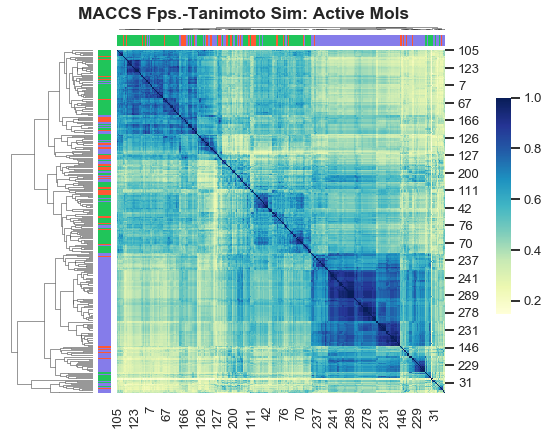

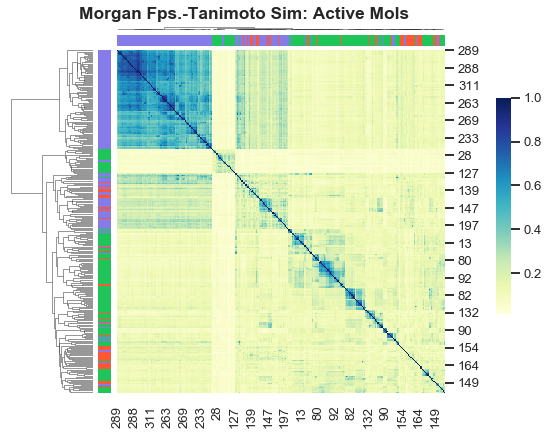

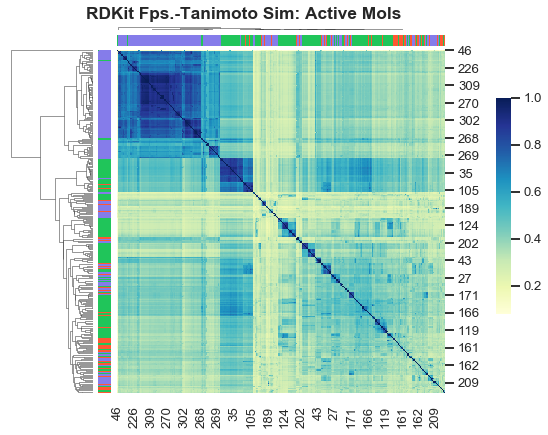

In [228]:
#*********************
# Plot the clustermaps
#*********************
clusmap_maccs = plot_cluster_map(siml_mtx_maccs, title='MACCS Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
clusmap_morgan = plot_cluster_map(siml_mtx_morgan, title='Morgan Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
clusmap_rdk = plot_cluster_map(siml_mtx_rdk, title='RDKit Fps.-Tanimoto Sim: Active Mols',
                    col_cluster=True, row_cluster=True, dendrogram_ratio=(0.2, 0.01), figsize=(7,6))
plt.show()

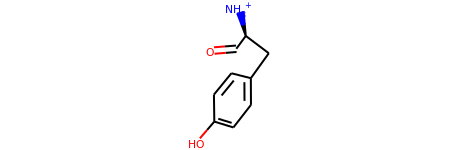

In [212]:
# In the RDKit Fps set, this molecule differs from all other actives
df_all_mols.loc[46, 'mol_rdk']


## Murcko Scaffold

In [ ]:
from rdkit.Chem.Scaffolds import MurckoScaffold as Murko
from rdkit.Chem import rdDepictor

In [ ]:
mol_rpr = lig_datasets['COCRYS'].loc['RPR', 'mol_rdk']
rdDepictor.Compute2DCoords(mol_rpr)
mol_rpr

In [ ]:
Murko.GetScaffoldForMol(mol_rpr)

In [ ]:
# generic
Murko.MakeScaffoldGeneric(mol_rpr)

In [ ]:
mol_rpr = lig_datasets['COCRYS'].loc['4O4', 'mol_rdk']
rdDepictor.Compute2DCoords(mol_rpr)
mol_rpr

In [ ]:
Murko.GetScaffoldForMol(mol_rpr)

In [ ]:
Murko.GetScaffoldForMol(mol_rpr)